In [21]:
# Import Libraries
# Purpose: Load all necessary Python libraries for data handling, ML, and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.manifold import TSNE  # Import t-SNE

print("Libraries imported successfully!")

Libraries imported successfully!


In [22]:
# Step 1 - Load the MIMIC-III Demo Data
# Purpose: Load the CSV files into Pandas DataFrames
# Note: Files should be in your working directory

patients = pd.read_csv("data/PATIENTS.csv")           # Patient demographics (SUBJECT_ID, GENDER, DOB)
labevents = pd.read_csv("data/LABEVENTS.csv")         # Lab results (SUBJECT_ID, ITEMID, VALUENUM)
diagnoses_icd = pd.read_csv("data/DIAGNOSES_ICD.csv") # ICD-9 diagnosis codes (SUBJECT_ID, ICD9_CODE)

# Display the first few rows to confirm loading
print("Patients Data Preview:")
print(patients.head())
print("\nLab Events Preview:")
print(labevents.head())
print("\nDiagnoses ICD Preview:")
print(diagnoses_icd.head())


Patients Data Preview:
   ROW_ID  SUBJECT_ID GENDER                  DOB                  DOD  \
0     234         249      F  2075-03-13 00:00:00                  NaN   
1     235         250      F  2164-12-27 00:00:00  2188-11-22 00:00:00   
2     236         251      M  2090-03-15 00:00:00                  NaN   
3     237         252      M  2078-03-06 00:00:00                  NaN   
4     238         253      F  2089-11-26 00:00:00                  NaN   

              DOD_HOSP DOD_SSN  EXPIRE_FLAG  
0                  NaN     NaN            0  
1  2188-11-22 00:00:00     NaN            1  
2                  NaN     NaN            0  
3                  NaN     NaN            0  
4                  NaN     NaN            0  

Lab Events Preview:
   ROW_ID  SUBJECT_ID  HADM_ID  ITEMID            CHARTTIME VALUE  VALUENUM  \
0     281           3      NaN   50820  2101-10-12 16:07:00  7.39      7.39   
1     282           3      NaN   50800  2101-10-12 18:17:00   ART       NaN  

In [23]:
# Step 2 - Extract Liver-Related Data
# Purpose: Filter and merge data relevant to liver failure with expanded liver items

# Define liver-related lab items from LABEVENTS
liver_items = {
    50885: 'total_bilirubin',
    50883: 'direct_bilirubin',
    50983: 'ALT',
    50878: 'AST',
    50861: 'alkaline_phosphatase',
    50902: 'albumin',
    50862: 'ammonia',
    50931: 'ggt',
    50960: 'lactate',
}

# Filter LABEVENTS for liver labs
lab_liver = labevents[labevents['ITEMID'].isin(liver_items.keys())].copy()
lab_liver['lab_name'] = lab_liver['ITEMID'].map(liver_items)

# Pivot to get one row per patient with mean lab values, drop duplicates
lab_pivot = lab_liver.pivot_table(index='SUBJECT_ID', columns='lab_name', 
                                  values='VALUENUM', aggfunc='mean').reset_index()
lab_pivot = lab_pivot.drop_duplicates(subset=['SUBJECT_ID'])  # Deduplicate by SUBJECT_ID

# Merge with patient demographics
data = pd.merge(patients[['SUBJECT_ID', 'GENDER', 'DOB']], 
                lab_pivot, on='SUBJECT_ID', how='left')

# Calculate age using a more appropriate reference year
data['age'] = (2150 - pd.to_datetime(data['DOB']).dt.year).clip(lower=0, upper=90)
data = data.drop(columns=['DOB'])

# Encode gender (M = 1, F = 0)
data['GENDER'] = data['GENDER'].map({'M': 1, 'F': 0})

# Define actual liver failure based on ICD-9 codes
liver_icd_codes = ['5722', '5715', '07032']
liver_diagnoses = diagnoses_icd[diagnoses_icd['ICD9_CODE'].isin(liver_icd_codes)]['SUBJECT_ID'].unique()
data['actual_liver_failure'] = np.where(data['SUBJECT_ID'].isin(liver_diagnoses), 1, 0)

# Define predicted risk based solely on ICD-9 (remove bilirubin dependency)
data['liver_failure_risk'] = np.where(data['SUBJECT_ID'].isin(liver_diagnoses), 1, 0)

# Fill missing values with median
numeric_cols = ['age', 'total_bilirubin', 'direct_bilirubin', 'ALT', 'AST', 
                'alkaline_phosphatase', 'albumin', 'ammonia', 'ggt', 'lactate']
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

print("Missing Data Check (after imputation):")
print(data[numeric_cols].isna().sum())
print("Extracted Liver Data Preview:")
print(data.head())

Missing Data Check (after imputation):
age                     0
total_bilirubin         0
direct_bilirubin        0
ALT                     0
AST                     0
alkaline_phosphatase    0
albumin                 0
ammonia                 0
ggt                     0
lactate                 0
dtype: int64
Extracted Liver Data Preview:
   SUBJECT_ID  GENDER         ALT        AST     albumin  \
0         249       0  140.461538  50.428571  103.390625   
1         250       0  136.647059  40.625000  103.558824   
2         251       1  137.333333  32.000000  104.000000   
3         252       1  142.476190  41.153846  111.921053   
4         253       0  138.166667  28.000000  103.333333   

   alkaline_phosphatase   ammonia  direct_bilirubin         ggt   lactate  \
0             64.714286  3.350000               0.3  132.096774  1.985000   
1             11.500000  2.020000               0.3  124.757576  1.871429   
2             26.833333  4.000000               0.3   99.333333  1

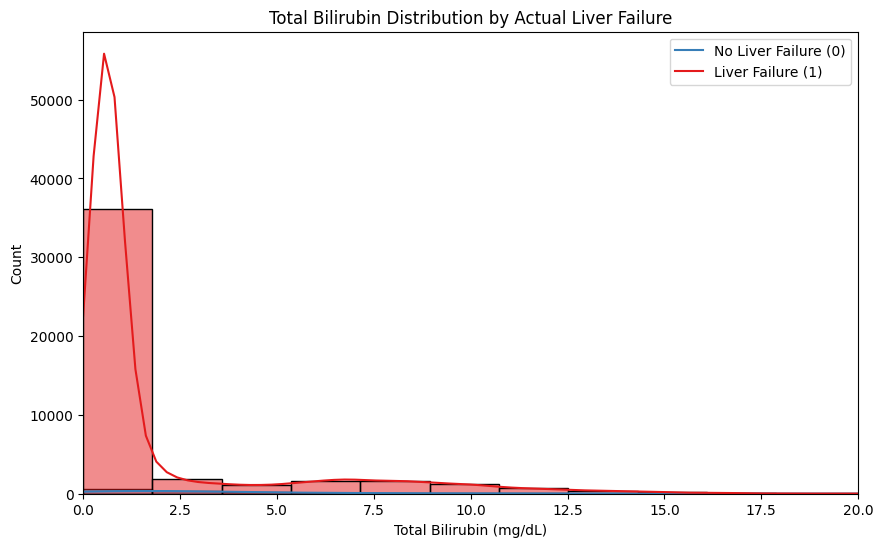

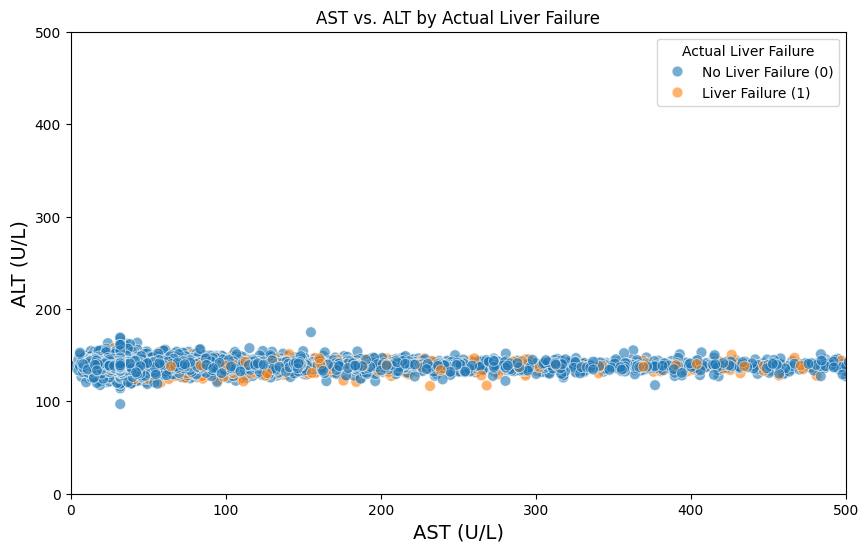

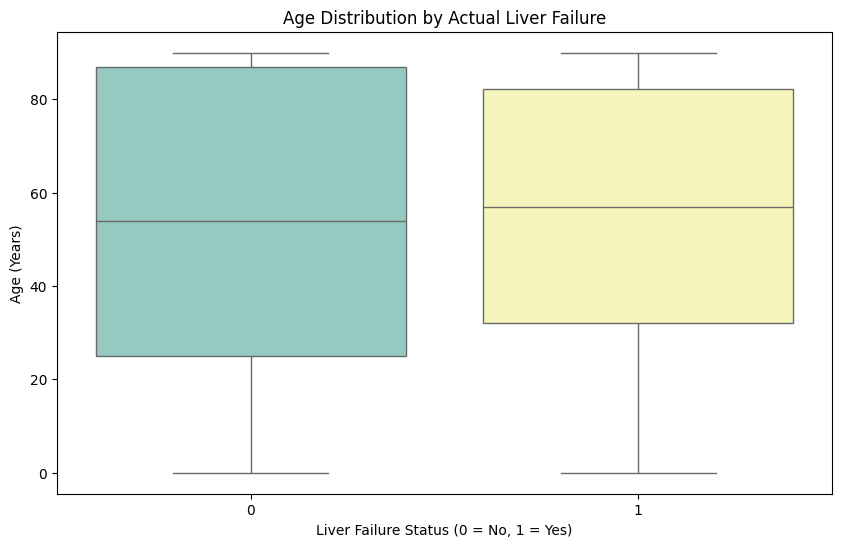

<Figure size 1200x800 with 0 Axes>

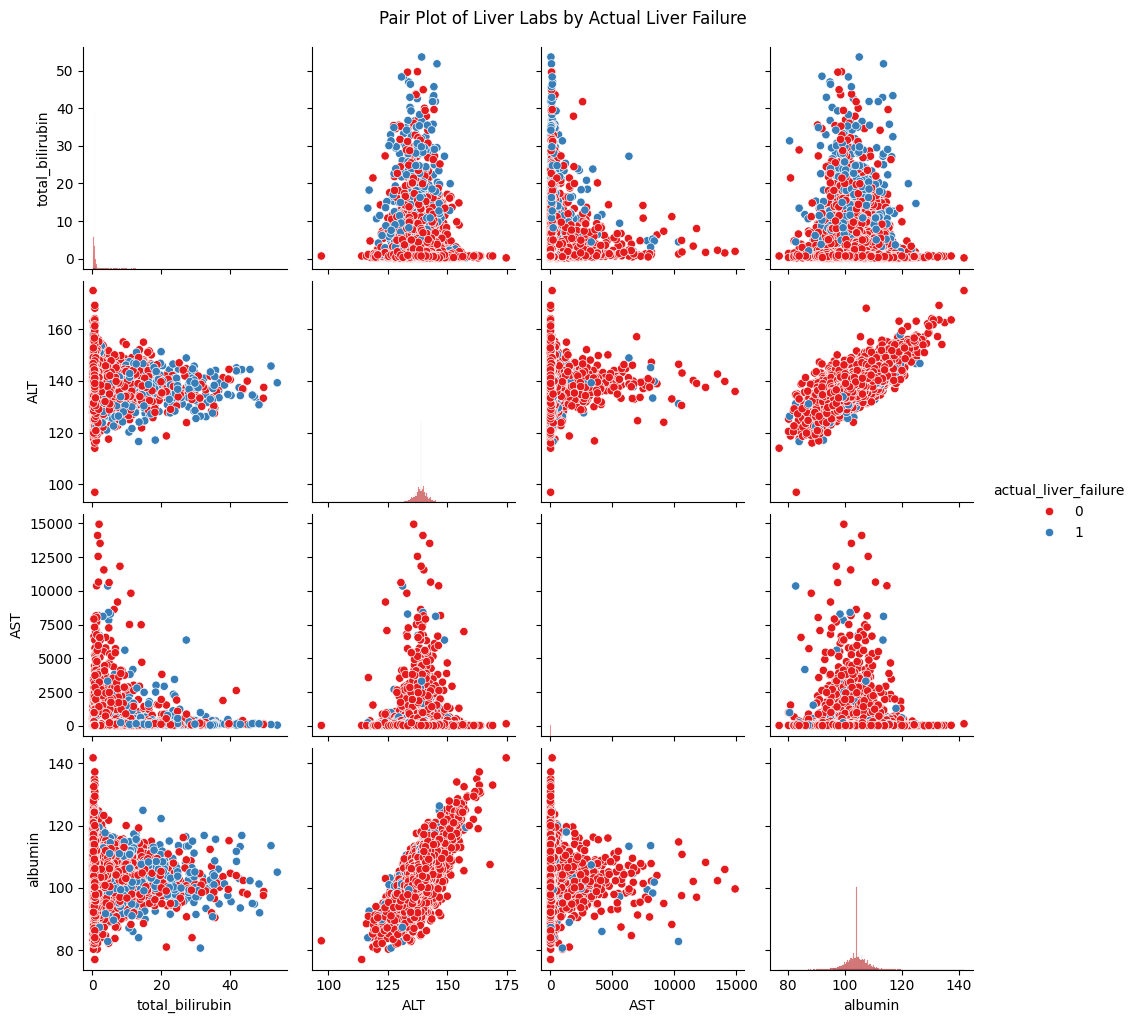

In [24]:
# Step 3 - Understand the Data with Plots

# Plot 1: Total Bilirubin Distribution
# This histogram shows the distribution of total bilirubin levels in patients,
# categorized by whether they have actual liver failure or not.
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='total_bilirubin', hue='actual_liver_failure', bins=30, kde=True, palette='Set1')
plt.title("Total Bilirubin Distribution by Actual Liver Failure")
plt.xlabel("Total Bilirubin (mg/dL)")  # X-axis represents bilirubin concentration
plt.ylabel("Count")  # Y-axis represents the number of patients
plt.legend(labels=['No Liver Failure (0)', 'Liver Failure (1)'])  # Legend for clarity
plt.xlim(0, 20)  # Restricting x-axis to improve visibility
plt.show()

# Plot 2: AST vs. ALT Scatterplot
# This scatterplot visualizes the relationship between AST and ALT enzyme levels,
# which are key indicators of liver function.
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=data, x='AST', y='ALT', hue='actual_liver_failure', palette='tab10', alpha=0.6, s=60)
plt.title("AST vs. ALT by Actual Liver Failure")
plt.xlabel("AST (U/L)", fontsize=14)  # Aspartate Aminotransferase (AST) levels
plt.ylabel("ALT (U/L)", fontsize=14)  # Alanine Aminotransferase (ALT) levels
plt.xlim(0, 500)  # Limiting x-axis range for better focus
plt.ylim(0, 500)  # Limiting y-axis range for better focus

# Fixing the legend to match the first plot format
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['No Liver Failure (0)', 'Liver Failure (1)'], title="Actual Liver Failure")
plt.show()

# Plot 3: Age Distribution
# This boxplot displays the distribution of patient ages, separated by liver failure status.
plt.figure(figsize=(10, 6))
sns.boxplot(x='actual_liver_failure', y='age', data=data, hue='actual_liver_failure', palette='Set3', legend=False)
plt.title("Age Distribution by Actual Liver Failure")
plt.xlabel("Liver Failure Status (0 = No, 1 = Yes)")  # X-axis represents liver failure status
plt.ylabel("Age (Years)")  # Y-axis represents patient age distribution
plt.show()

# Plot 4: Pair Plot
# This pair plot provides an overview of relationships between different liver-related metrics.
plt.figure(figsize=(12, 8))
pair_cols = ['total_bilirubin', 'ALT', 'AST', 'albumin', 'actual_liver_failure']  # Selecting key features
sns.pairplot(data=data[pair_cols], hue='actual_liver_failure', palette='Set1', diag_kind='hist')  # Histograms on diagonal
plt.suptitle("Pair Plot of Liver Labs by Actual Liver Failure", y=1.02)  # Title with spacing for better visibility
plt.show()


In [25]:
# Step 4 - Prepare Data for Machine Learning

# Define the features to be used for training the model.
# These include demographic data (age, gender) and various liver-related lab results.
features = ['age', 'GENDER', 'total_bilirubin', 'direct_bilirubin', 'ALT', 'AST', 
            'alkaline_phosphatase', 'albumin', 'ammonia', 'ggt', 'lactate']

# Extract features (X) and target variable (y)
X = data[features]  # Feature matrix containing predictor variables
y = data['liver_failure_risk']  # Target variable representing liver failure risk

# Split data into training and testing sets
# 80% training data, 20% testing data, ensuring reproducibility with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets to verify correctness
print("Training set shape:", X_train.shape)  # Output shape of training set
print("Testing set shape:", X_test.shape)  # Output shape of testing set


Training set shape: (37216, 11)
Testing set shape: (9304, 11)


In [26]:
# Step 4 - Apply the Random Forest Model

# Initialize the Random Forest Classifier with 100 trees (n_estimators)
# Setting random_state=42 ensures reproducibility of results
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train (fit) the model using the training dataset
rf_model.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = rf_model.predict(X_test)  # Predicted class labels (0 or 1)

# Get probability scores for each prediction (useful for evaluating confidence)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Extract probability of class 1 (liver failure)

# Print confirmation message after training completion
print("Model training completed!")


Model training completed!


### Understanding the Random Forest Model and Plots
- **Random Forest**: A collection of 100 decision trees that vote on liver failure risk. Each tree makes a guess, and the majority wins. It’s robust and reduces overfitting.
  - **Parameters**: 100 trees (n_estimators) for stability, random_state=42 for reproducibility.
- **Feature Importance Plot**: Bar chart showing each feature’s contribution, sorted.
  - X-axis: Importance score (0-1), Y-axis: Features.
- **Normalized Confusion Matrix**: Heatmap showing proportions of predictions.
  - Rows: Actual (0 = No, 1 = Yes), Columns: Predicted (0 = No, 1 = Yes).
- **Precision-Recall Curve**: Plots precision vs. recall for imbalanced data.
  - Includes Average Precision score.
- **Predicted Probability Distribution**: Histogram of predicted probabilities, split by actual liver failure.
  - X-axis: Predicted probability, Y-axis: Count.
- **2D Density Plot**: Visualizes Total Bilirubin vs. AST with predicted risk.
  - Insight: Identifies feature interactions driving predictions.
- **t-SNE Plot**: 2D visualization of high-dimensional data, colored by class.
  - Insight: Shows separation between liver failure and no liver failure cases.

Accuracy: 0.97 - Percentage of correct predictions
AUC-ROC: 0.91 - Ability to distinguish risk vs. no risk


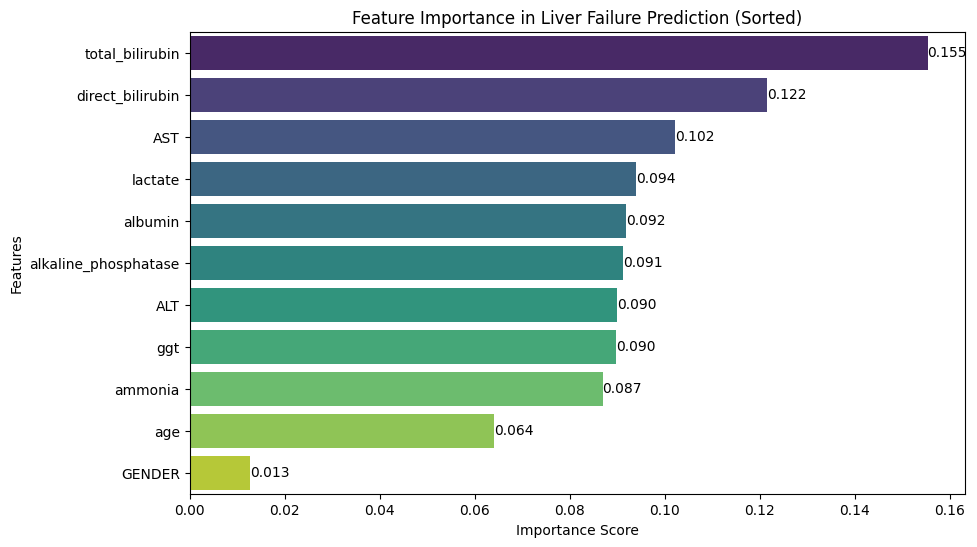

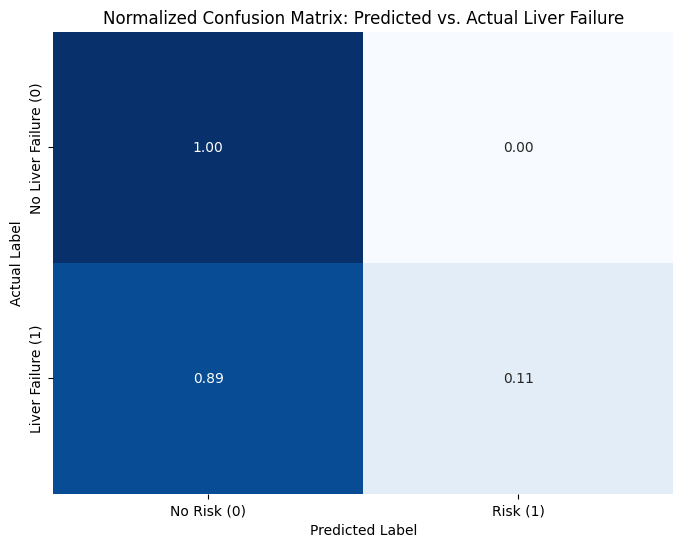

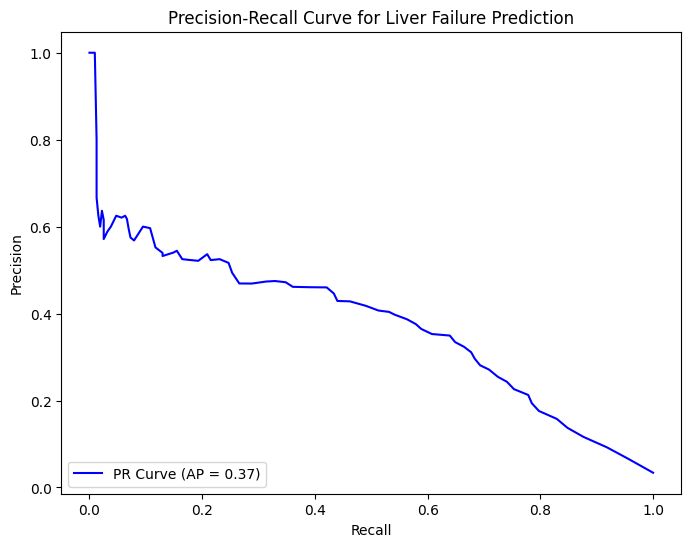

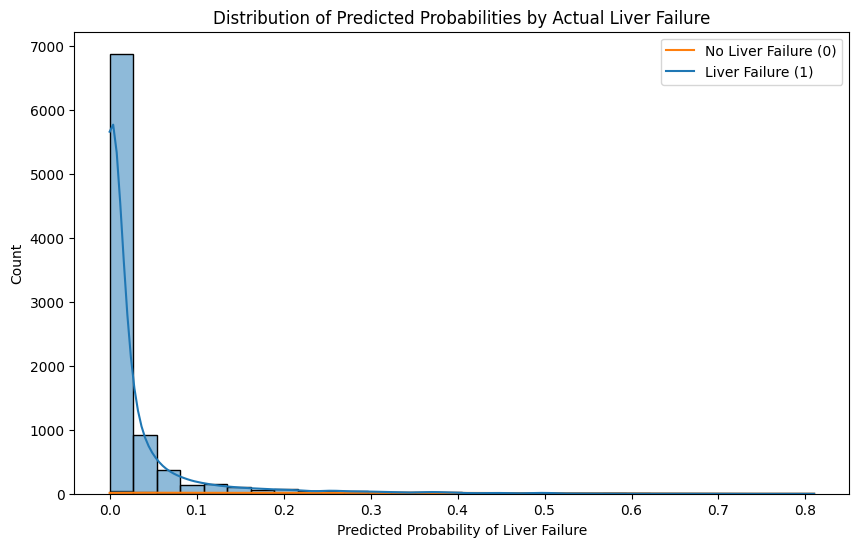

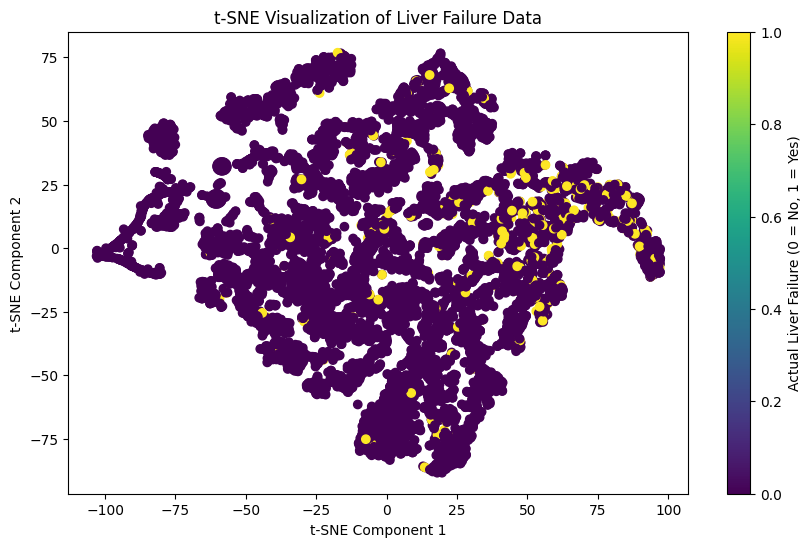

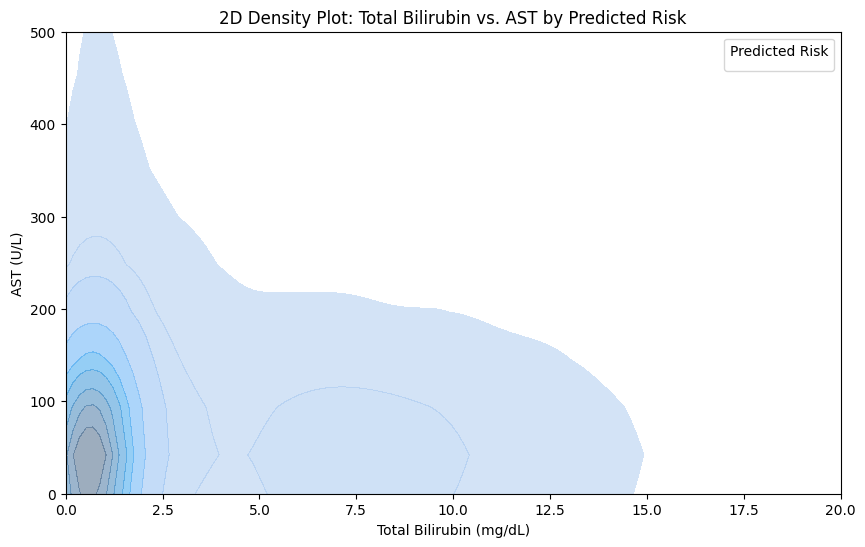

In [27]:
# Step 5 - Analyze and Visualize Results

# Calculate key evaluation metrics
accuracy = accuracy_score(y_test, y_pred)  # Percentage of correctly classified samples
auc = roc_auc_score(y_test, y_pred_proba)  # Area Under the ROC Curve (discriminatory power)
print(f"Accuracy: {accuracy:.2f} - Percentage of correct predictions")
print(f"AUC-ROC: {auc:.2f} - Ability to distinguish risk vs. no risk")

# Plot 5: Feature Importance (Sorted)
# This bar plot visualizes the most important features contributing to liver failure predictions.
plt.figure(figsize=(10, 6))
importances = rf_model.feature_importances_  # Extract feature importance scores
indices = np.argsort(importances)[::-1]  # Sort in descending order
sorted_features = [features[i] for i in indices]  # Retrieve sorted feature names
sorted_importances = importances[indices]  # Retrieve sorted importance scores

sns.barplot(x=sorted_importances, y=sorted_features, hue=sorted_features, palette='viridis', legend=False)
for i, v in enumerate(sorted_importances):
    plt.text(v, i, f'{v:.3f}', va='center')  # Add labels for better readability
plt.title("Feature Importance in Liver Failure Prediction (Sorted)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Plot 6: Normalized Confusion Matrix
# This heatmap shows the model's performance in predicting liver failure risk.
test_data = X_test.copy()
test_data['predicted_risk'] = y_pred  # Add predicted labels to the test dataset
test_data['actual_liver_failure'] = data.loc[X_test.index, 'actual_liver_failure']  # Add actual labels

# Compute and normalize confusion matrix
cm = confusion_matrix(test_data['actual_liver_failure'], test_data['predicted_risk'])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize per row

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['No Risk (0)', 'Risk (1)'], yticklabels=['No Liver Failure (0)', 'Liver Failure (1)'])
plt.title("Normalized Confusion Matrix: Predicted vs. Actual Liver Failure")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Plot 7: Precision-Recall Curve
# This curve shows the trade-off between precision and recall, useful for imbalanced datasets.
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AP = {ap:.2f})')
plt.title("Precision-Recall Curve for Liver Failure Prediction")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')
plt.show()

# Plot 8: Predicted Probability Distribution
# This histogram visualizes how confident the model is in its predictions.
test_data['predicted_proba'] = y_pred_proba

plt.figure(figsize=(10, 6))
sns.histplot(data=test_data, x='predicted_proba', hue='actual_liver_failure', bins=30, kde=True)
plt.legend(title="Actual Liver Failure", labels=['No Liver Failure (0)', 'Liver Failure (1)'])
plt.title("Distribution of Predicted Probabilities by Actual Liver Failure")
plt.xlabel("Predicted Probability of Liver Failure")
plt.ylabel("Count")
plt.legend(labels=['No Liver Failure (0)', 'Liver Failure (1)'])
plt.show()

# Plot 9: t-SNE Visualization
# t-SNE reduces high-dimensional data to 2D for visualization of clustering.
tsne = TSNE(n_components=2, random_state=42, perplexity=30)  # Perplexity controls the balance between local/global structure
X_tsne = tsne.fit_transform(X_test)  # Apply t-SNE transformation

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=test_data['actual_liver_failure'], cmap='viridis')
plt.colorbar(scatter, label='Actual Liver Failure (0 = No, 1 = Yes)')  # Add color legend
plt.title("t-SNE Visualization of Liver Failure Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Plot 10: 2D Density Plot (Total Bilirubin vs. AST)
# This KDE plot shows the density distribution of patients based on bilirubin and AST levels.
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(
    data=test_data, x='total_bilirubin', y='AST', hue='predicted_risk', 
    fill=True, alpha=0.5
)

# Fix legend issue to match other plots
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, title="Predicted Risk", loc="upper right")
plt.title("2D Density Plot: Total Bilirubin vs. AST by Predicted Risk")
plt.xlabel("Total Bilirubin (mg/dL)")
plt.ylabel("AST (U/L)")
plt.xlim(0, 20)  # Limit x-axis for better visibility
plt.ylim(0, 500)  # Limit y-axis to relevant AST values
plt.show()


In [28]:
# Conclusion
print("Tutorial Summary:")
print("- Loaded MIMIC-III demo data from 3 CSV files.")
print("- Extracted expanded liver labs and defined failure using ICD-9.")
print("- Visualized patterns with bilirubin, AST/ALT, age, and a pair plot.")
print("- Built a Random Forest model to predict liver failure risk.")
print("- Evaluated with accuracy, precision-recall, t-SNE, and density plots.")
print("Key Takeaway: ML can identify liver failure risk in ICU patients!")

Tutorial Summary:
- Loaded MIMIC-III demo data from 3 CSV files.
- Extracted expanded liver labs and defined failure using ICD-9.
- Visualized patterns with bilirubin, AST/ALT, age, and a pair plot.
- Built a Random Forest model to predict liver failure risk.
- Evaluated with accuracy, precision-recall, t-SNE, and density plots.
Key Takeaway: ML can identify liver failure risk in ICU patients!
